### Problem Description

in this dataset we will be tackling the sentiment analysis problem we have comments from different tweets and we will ty to predict whether the comment is positive or negative 
you can find the link to the dataset through <a href="https://www.kaggle.com/kazanova/sentiment140">here</a>

### Import Packages

In [5]:
# Add environment Packages paths to conda
import os, sys
env_name = "food_review"
sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arsany\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arsany\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arsany\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Arsany\.virtualenvs\app-o3sMwJAe\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Read Dataset

In [6]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 4.87 s


In [7]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [8]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [9]:
## Write your code here
df_text.drop_duplicates(inplace=True)

### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [10]:
df_text['target'] = df_text.Score.apply(lambda score:0 if score<3 else 1)

#### Plot Countplot for target Variable

C:\Users\Arsany\.virtualenvs\app-o3sMwJAe\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

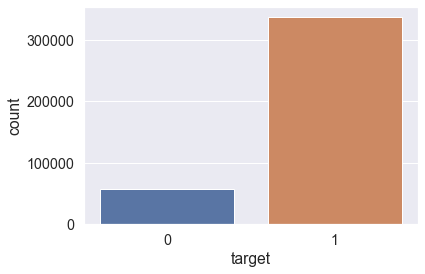

In [11]:
## Write your code here
sns.countplot(df_text["target"])

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [12]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.loc[df_pos.index], df_text[df_text.target == 0]])

C:\Users\Arsany\.virtualenvs\app-o3sMwJAe\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

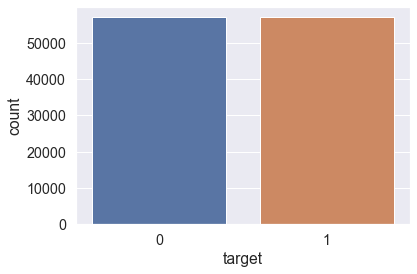

In [13]:
## PLot the target again after balancing
## Write your code here
sns.countplot(df_text_balanced['target'])

### Text Pre-Processing

In [14]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [15]:
## Clean your reviews using stemmer, lemmatizer & stopwords

def cleaner(sentece):
    word_list=nltk.word_tokenize(sentece)
    clean_word_list=[]
    for word in word_list:
        if word.lower() not in stop_words:
            lemma=lemmatizer.lemmatize(word)
            stemmed=stemmer.stem(lemma)
            clean_word_list.append(stemmed)
    return " ".join(clean_word_list)
df_text_balanced["clean_Text"]=df_text_balanced.Text.apply(cleaner,)

In [16]:
df_text_balanced.head(5)

,Text,Score,target,clean_Text
274649,tastes delicious and is cheaper than from thei...,4,1,tast delici cheaper site ! ! ! easili mix wate...
262755,I know that this doesn't really taste like the...,5,1,know n't realli tast like fresh ' coconut wate...
237555,The picture for this item shows the top of the...,5,1,"pictur item show top screw damper flat , one r..."
82871,The San Francisco Bay french roast K-cups are ...,5,1,san francisco bay french roast k-cup excel cho...
350146,I used to buy these little packets of my favor...,5,1,use buy littl packet favorit diet snappl flavo...


### Split Test & Training Data

In [17]:
X = df_text_balanced.clean_Text
y = df_text_balanced.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [18]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer.transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [19]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 44131), (34251, 44131))

### Modelling

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [21]:
## initialize your Model
clf = RandomForestClassifier(n_jobs=4) 
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.14%


### Raw Instance Prediction

In [22]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = review
    # Embed review using tf-idf vectorizer
    cleaner(review_c)
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [23]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [24]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [25]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [26]:
import pickle

In [27]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('app_model/', model_name)
vect_path = os.path.join('app_model/', vectorizer_name)
# save
with open(model_path,'wb') as f:
    pickle.dump(clf,f)
with open(vect_path,'wb') as f:
    pickle.dump(vectorizer,f)


### Load model Again and test them

In [28]:
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)
with open(vect_path, 'rb') as f:
    loaded_vect = pickle.load(f)

In [29]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [30]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework